## Data transformation
Before starting with classification, we will transform data and normalize in order to compute distances. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

In [3]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [4]:
# importing dataset

df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

In [5]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4

#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

### Filling of NaN values

In [6]:
#Dealing with mode attribute missing values - train
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
list_of_nan_indexes_train=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_train:
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0

In [7]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]

Let's check if everything is fine

In [8]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [9]:
df_train['genre'].value_counts()

genre
j-dance          750
iranian          750
brazil           750
chicago-house    750
forro            750
idm              750
indian           750
study            750
disney           750
afrobeat         750
mandopop         750
techno           750
sleep            750
spanish          750
j-idol           750
industrial       750
happy            750
bluegrass        750
black-metal      750
breakbeat        750
Name: count, dtype: int64

### Outlier criteria
For now, we do not consider any point as outlier because none of them miss the classification label and considering that this time one of our tasks is to distinguish between musical genra and not-musical genra. 

### Eliminating redundant features

In [10]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [11]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats', 'loudness'] 
df_train.drop(column2drop, axis=1, inplace=True)

In [12]:
df_train.head()

,duration_min,explicit,popularity_percent,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,4.029333,False,0.46,0.690,0.513,5,1.0,0.0975,0.302000,0.53600,0.281,0.6350,142.221,4.0,j-dance
1,7.400000,False,0.00,0.069,0.196,1,0.0,0.0805,0.283000,0.93400,0.360,0.0336,75.596,4.0,iranian
2,5.558433,False,0.03,0.363,0.854,2,0.0,0.0397,0.000089,0.80000,0.262,0.4890,116.628,4.0,black-metal
3,4.496667,False,0.23,0.523,0.585,5,1.0,0.0765,0.066400,0.00127,0.117,0.3850,140.880,4.0,bluegrass
4,5.127517,False,0.25,0.643,0.687,7,1.0,0.0539,0.000576,0.09690,0.299,0.6370,143.956,4.0,happy


#### Encoding attributes for pattern mining 

Encoding continuous variables using percentiles. 

In [13]:
#bins the continuous attributes using quartile distribution
df_train["duration_min_bin"] = pd.qcut(df_train["duration_min"], 4)
df_train["popularity_percent_bin"] = pd.qcut(df_train["popularity_percent"], 4)
df_train["danceability_bin"] = pd.qcut(df_train["danceability"], 4)
df_train["energy_bin"] = pd.qcut(df_train["energy"], 4)
df_train["speechiness_bin"] = pd.qcut(df_train["speechiness"], 4)
df_train["acousticness_bin"] = pd.qcut(df_train["acousticness"], 4)
df_train["instrumentalness_bin"] = pd.qcut(df_train["instrumentalness"], 4, duplicates='drop')
df_train["liveness_bin"] = pd.qcut(df_train["liveness"], 4)
df_train["valence_bin"] = pd.qcut(df_train["valence"], 4)
df_train["tempo_bin"] = pd.qcut(df_train["tempo"], 4)





df_train.drop(["duration_min", "popularity_percent", "danceability", "energy", 
               "speechiness", "acousticness", "instrumentalness", 
               "liveness", "valence", "tempo"], axis=1, inplace=True)


In [14]:
df_train["duration_min_bin"] = df_train["duration_min_bin"].astype(str) + "_minutes"
df_train["popularity_percent_bin"] = df_train["popularity_percent_bin"].astype(str) + "_popularity"
df_train["danceability_bin"] = df_train["danceability_bin"].astype(str) + "_dance"
df_train["energy_bin"] = df_train["energy_bin"].astype(str) + "_energy"
df_train["speechiness_bin"] = df_train["speechiness_bin"].astype(str) + "_speech"
df_train["acousticness_bin"] = df_train["acousticness_bin"].astype(str) + "_acoustic"
df_train["instrumentalness_bin"] = df_train["instrumentalness_bin"].astype(str) + "_instru"
df_train["liveness_bin"] = df_train["liveness_bin"].astype(str) + "_liveness"
df_train["valence_bin"] = df_train["valence_bin"].astype(str) + "_valence"
df_train["tempo_bin"] = df_train["tempo_bin"].astype(str) + "_tempo"


In [15]:
from sklearn.preprocessing import LabelEncoder

#### Encoding `explicit`

In [16]:
#just a trial, encoding the bool attribute `explicit`
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])

In [17]:
df_train.head()

,explicit,key,mode,time_signature,genre,duration_min_bin,popularity_percent_bin,danceability_bin,energy_bin,speechiness_bin,acousticness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,0,5,1.0,4.0,j-dance,"(3.797, 4.815]_minutes","(0.42, 0.94]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(0.0886, 0.939]_speech","(0.155, 0.573]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"
1,0,1,0.0,4.0,iranian,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(-0.001, 0.48]_energy","(0.051, 0.0886]_speech","(0.155, 0.573]_acoustic","(0.744, 1.0]_instru","(0.28, 0.994]_liveness","(-0.001, 0.196]_valence","(-0.001, 99.939]_tempo"
2,0,2,0.0,4.0,black-metal,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(0.709, 0.884]_energy","(0.0373, 0.051]_speech","(-0.001, 0.00974]_acoustic","(0.744, 1.0]_instru","(0.131, 0.28]_liveness","(0.416, 0.664]_valence","(99.939, 124.188]_tempo"
3,0,5,1.0,4.0,bluegrass,"(3.797, 4.815]_minutes","(0.14, 0.24]_popularity","(0.441, 0.58]_dance","(0.48, 0.709]_energy","(0.051, 0.0886]_speech","(0.00974, 0.155]_acoustic","(-0.001, 0.00313]_instru","(0.0979, 0.131]_liveness","(0.196, 0.416]_valence","(124.188, 141.986]_tempo"
4,0,7,1.0,4.0,happy,"(4.815, 68.671]_minutes","(0.24, 0.42]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(0.051, 0.0886]_speech","(-0.001, 0.00974]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"


In [18]:
X = df_train.values.tolist() #Apriori needs to work with a list not a np array

In [19]:
X

[[0,
  5,
  1.0,
  4.0,
  'j-dance',
  '(3.797, 4.815]_minutes',
  '(0.42, 0.94]_popularity',
  '(0.58, 0.695]_dance',
  '(0.48, 0.709]_energy',
  '(0.0886, 0.939]_speech',
  '(0.155, 0.573]_acoustic',
  '(0.00313, 0.744]_instru',
  '(0.28, 0.994]_liveness',
  '(0.416, 0.664]_valence',
  '(141.986, 220.525]_tempo'],
 [0,
  1,
  0.0,
  4.0,
  'iranian',
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(-0.001, 0.48]_energy',
  '(0.051, 0.0886]_speech',
  '(0.155, 0.573]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.28, 0.994]_liveness',
  '(-0.001, 0.196]_valence',
  '(-0.001, 99.939]_tempo'],
 [0,
  2,
  0.0,
  4.0,
  'black-metal',
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(0.709, 0.884]_energy',
  '(0.0373, 0.051]_speech',
  '(-0.001, 0.00974]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.131, 0.28]_liveness',
  '(0.416, 0.664]_valence',
  '(99.939, 124.188]_tempo'],
 [0,
  5,
  1.0,
  4.0,
  'bluegrass'

## Pattern mining 

In [20]:
from fim import apriori

In [21]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

#### Search for itemsets with min support

In [22]:
# supp = 2  # 2%
supp = 20  # 20%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="S", eval='lift')
print(f'The number of frequent itemsets considering supp={supp}% and zmin={2} is {len(itemsets)}')
pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])

The number of frequent itemsets considering supp=20% and zmin=2 is 113


,frequent_itemset,support
0,"((0.14, 0.24]_popularity, 4.0)",21.626667
1,"((0.14, 0.24]_popularity, 4.0, 0)",20.600000
2,"((0.14, 0.24]_popularity, 0)",23.040000
3,"((0.131, 0.28]_liveness, 4.0)",21.780000
4,"((0.131, 0.28]_liveness, 4.0, 0)",20.840000
...,...,...
108,"((-0.001, 0.00313]_instru, 0)",47.766667
109,"(1.0, 4.0)",60.040000
110,"(1.0, 4.0, 0)",57.120000
111,"(1.0, 0)",65.933333


#### Searching for maximum and closed itemsets as a function of minsupport - stopping at `max_supp = 30`. 

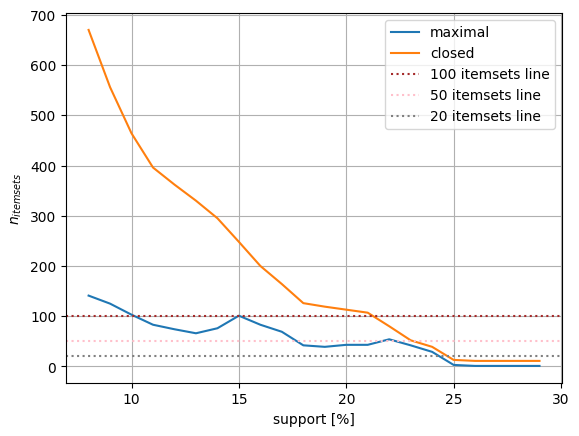

In [23]:
len_max_it = []
len_cl_it = []
max_supp = 30
for i in range(8, max_supp):
    max_itemsets = apriori(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(X, target="c", supp=i, zmin=zmin)
    if len(max_itemsets) == 0:
        print(f'The maximum existing support has been exceeded, max_supp = {i-1}')
        break
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))

plt.plot(np.arange(8, max_supp), len_max_it, label="maximal")
plt.plot(np.arange(8, max_supp), len_cl_it, label="closed")
plt.axhline(100, color='brown', linestyle='dotted', label='100 itemsets line')
plt.axhline(50, color='pink', linestyle='dotted', label='50 itemsets line')
plt.axhline(20, color='gray',linestyle='dotted', label='20 itemsets line')
plt.grid()
plt.legend()
plt.xlabel("support [%]")
plt.ylabel(r"$n_{itemsets}$")

plt.show()

Need to understand more deeply the importance of this kind of itemsets. 

#### Searching for the maxsupport rule and its interpretation

In [24]:
# supp = 2  # 2%
supp = 84  # 20%
zmin = 2  # minimum number of items per item set

itemsets = apriori(X, target="s", supp=supp, zmin=zmin, report="Se", eval='lift')
pd.DataFrame(itemsets, columns=["frequent_itemset", "support","lift"])

,frequent_itemset,support,lift
0,"(4.0, 0)",84.486667,1.000545


In [25]:
supp = 84
conf = 50
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df

,consequent,antecedent,abs_support,%_support,confidence,lift
0,"(-0.001, 0.00313]_instru","(4.0, 0)",6479,43.193333,0.511244,1.022216
1,"(-0.001, 0.00313]_instru","(4.0,)",6754,45.026667,0.515140,1.030005
2,1.0,"(4.0, 0)",8568,57.120000,0.676083,0.975213
3,1.0,"(4.0,)",9006,60.040000,0.686904,0.990822
4,1.0,"(0,)",9890,65.933333,0.682493,0.984459
5,0,"(4.0,)",12673,84.486667,0.966593,1.000545
6,4.0,"(0,)",12673,84.486667,0.874543,1.000545


We can see a very high support but also a statistical independance. This pattern only shows the most probable values in a dataset, that is, most of data objects has `time_signature = 4`, `explicit = 0`. This is not a rule. 

#### Searching for rules with minsupp = 20%, conf = 60% with good lift and their interpretation

In [26]:
supp = 20
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.2

rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)


,consequent,antecedent,abs_support,%_support,confidence,lift
219,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy, 0)",2553,17.020000,0.684267,2.742187
218,"(-0.001, 0.48]_energy","((0.573, 0.996]_acoustic, 0)",2553,17.020000,0.687029,2.741537
221,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy,)",2560,17.066667,0.681032,2.729223
220,"(-0.001, 0.48]_energy","((0.573, 0.996]_acoustic,)",2560,17.066667,0.683943,2.729223
17,"(-0.001, 0.00313]_instru","((0.42, 0.94]_popularity, 4.0)",2431,16.206667,0.729373,1.458357
16,"(-0.001, 0.00313]_instru","((0.42, 0.94]_popularity, 4.0, 0)",2348,15.653333,0.727385,1.454383
19,"(-0.001, 0.00313]_instru","((0.42, 0.94]_popularity,)",2619,17.460000,0.706883,1.413388
18,"(-0.001, 0.00313]_instru","((0.42, 0.94]_popularity, 0)",2530,16.866667,0.704539,1.408703
124,"(-0.001, 0.00313]_instru","((0.155, 0.573]_acoustic, 4.0)",2320,15.466667,0.690887,1.381406
123,"(-0.001, 0.00313]_instru","((0.155, 0.573]_acoustic, 4.0, 0)",2227,14.846667,0.683758,1.367152


Some of these rules have a pretty high lift! Let's consider the first one and try to interpretate it. 

- `(-49.532, -10.636]_dB	((-0.001, 0.48]_energy, 0)` has higher lift: `lift = 2.787456`. This rule makes sense, it correlates lowest dB bin to to the lowest energy bin. It is valid but also not so eye-opening. Note that `explicit = 0` is not so interesting, we have seen that it has, with `time_signature =4.0`, a very high support so rules concerning those values are often not interesting.  
Note that a lot of rules come doubled with reversed consequent/antecedent, bc this algorithm is not finding whose is cause, whose is effect. 
- `(-0.001, 0.00313]_instru	((0.42, 0.94]_popularity, 4.0)	` has `lift = 1.457656`, that is, songs with low instrumentalness are often more famous (here, the 4.0 has no great interest, as above). The `support = 16.160000`, that is, this is, the 16% of songs have those characteristics (not so low!), cofidence is pretty high: 0.729023. NOTE THAT IT DOES NOT MEAN THAT HIGH INSTRU MEANS NO POPULARITY!
Most of rules has the lowest bin of instrumentalness as antecedent, I think that this means, more than the rest, that most of the songs has low instumentalness (and so, support higher than minsupp).

We now lowen the minsupport, hoping to find more rules, maybe some niche-genre ones (such as, high instrumentalness bins songs).

In [27]:
supp = 10
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.2
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 50)
rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
rules_masked_df

,consequent,antecedent,abs_support,%_support,confidence,lift
645,"(0.573, 0.996]_acoustic","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy, 0)",1204,8.026667,0.775773,3.108896
646,"(0.573, 0.996]_acoustic","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy)",1207,8.046667,0.775707,3.108631
474,"(-0.001, 0.48]_energy","((-0.001, 99.939]_tempo, (0.573, 0.996]_acoustic, 0)",1164,7.760000,0.768317,3.065909
476,"(-0.001, 0.48]_energy","((-0.001, 99.939]_tempo, (0.573, 0.996]_acoustic)",1166,7.773333,0.765092,3.053040
647,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy, (0.0979, 0.131]_liveness, 0)",1124,7.493333,0.730819,2.928744
648,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy, (0.0979, 0.131]_liveness)",1127,7.513333,0.728036,2.917591
338,"(-0.001, 0.196]_valence","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy)",1135,7.566667,0.729434,2.911527
336,"(-0.001, 0.196]_valence","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy, 0)",1132,7.546667,0.729381,2.911315
333,"(0.573, 0.996]_acoustic","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy, 0)",1161,7.740000,0.724719,2.904298
334,"(0.573, 0.996]_acoustic","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy)",1164,7.760000,0.723881,2.900937


Clearly, lift is higher bc we are considering lower support rules. 
- `(-0.001, 0.48]_energy	((-49.532, -10.636]_dB, (0.573, 0.996]_acoustic, 1.0)` `support=9.260000`,`confidence= 0.888107`,`lift=3.543924` this is some kind of an extension of the rule above, in the set of `(-0.001, 0.48]_energy	((-49.532, -10.636]_dB`, there is a subgroup formed by `(0.573, 0.996]_acoustic` with 89% confidence. Considering the rule above, probably the true antecedent is `(0.573, 0.996]_acoustic` but this rule does not appear, probably bc of its low support (?).

#### Classification using pattern mining
Having regression failed in finding good correlation factors for `popularity` attribute, it is interesting to try finding the rules for the 'popular song'. 

In [28]:
rules_masked_df[rules_masked_df['antecedent'] == '(0.42, 0.94]_popularity']

,consequent,antecedent,abs_support,%_support,confidence,lift


Okay, this would make sense, let's lowen the support... (is it or not uncommon to become famous)?

In [29]:
supp = 10
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.2
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 50)
rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
rules_masked_df
#rules_masked_df[rules_masked_df['antecedent'] == '(0.42, 0.94]_popularity']

,consequent,antecedent,abs_support,%_support,confidence,lift
645,"(0.573, 0.996]_acoustic","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy, 0)",1204,8.026667,0.775773,3.108896
646,"(0.573, 0.996]_acoustic","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy)",1207,8.046667,0.775707,3.108631
474,"(-0.001, 0.48]_energy","((-0.001, 99.939]_tempo, (0.573, 0.996]_acoustic, 0)",1164,7.760000,0.768317,3.065909
476,"(-0.001, 0.48]_energy","((-0.001, 99.939]_tempo, (0.573, 0.996]_acoustic)",1166,7.773333,0.765092,3.053040
647,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy, (0.0979, 0.131]_liveness, 0)",1124,7.493333,0.730819,2.928744
648,"(0.573, 0.996]_acoustic","((-0.001, 0.48]_energy, (0.0979, 0.131]_liveness)",1127,7.513333,0.728036,2.917591
338,"(-0.001, 0.196]_valence","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy)",1135,7.566667,0.729434,2.911527
336,"(-0.001, 0.196]_valence","((-0.001, 0.441]_dance, (-0.001, 0.48]_energy, 0)",1132,7.546667,0.729381,2.911315
333,"(0.573, 0.996]_acoustic","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy, 0)",1161,7.740000,0.724719,2.904298
334,"(0.573, 0.996]_acoustic","((-0.001, 0.196]_valence, (-0.001, 0.48]_energy)",1164,7.760000,0.723881,2.900937


In [30]:
rules_masked_df['lift']

645    3.108896
646    3.108631
474    3.065909
476    3.053040
647    2.928744
648    2.917591
338    2.911527
336    2.911315
333    2.904298
334    2.900937
475    2.899135
477    2.893327
129    2.861382
128    2.860645
534    2.846859
535    2.827721
335    2.819700
337    2.816623
661    2.748758
662    2.744009
675    2.742187
674    2.741537
664    2.731540
677    2.729223
676    2.729223
665    2.725976
649    2.695699
650    2.668138
669    2.645563
672    2.634901
654    2.626971
658    2.612196
120    2.610310
119    2.601577
668    2.586540
653    2.578457
671    2.574645
657    2.561801
343    2.432474
345    2.421870
122    2.406178
121    2.405158
61     1.501692
58     1.498069
71     1.458357
69     1.454383
66     1.446884
64     1.441803
384    1.441734
381    1.423727
74     1.413388
389    1.412104
73     1.408703
387    1.390136
394    1.381406
253    1.375023
871    1.368012
392    1.367152
874    1.366064
248    1.365227
251    1.358497
397    1.353617
245    1

We have tried to lowen parameters but seems like it does not exist the recipe for success...  

#### Number of rule as a function of min_confidence

Now we fix the support to its defalut 10% and try to evaluate the trend of number of rule as a function of minimum confidence, and we will plot the maximum lift for every mincofidence value, in order to understand when the min_conf has a good value. 

In [31]:
#trend of number of rules as a function of min_confidence
min_conf_list = [50,60,70,75,80,85,90,95]
number_of_rules = []
mean_lift = []
for i in min_conf_list:
    supp = 10
    rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=i, report="aScl", eval = "lift")
    rules_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )
    mask_rules = rules_df['lift'] > 1.0
    rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
    number_of_rules.append(len(rules_masked_df))
    mean_lift.append(np.mean(rules_masked_df['lift']))
    

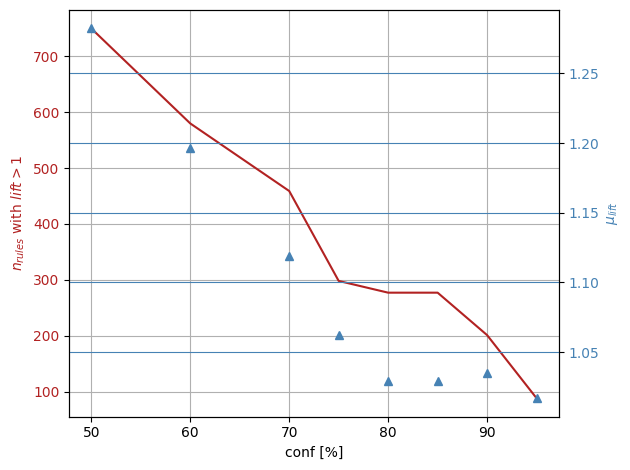

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()
ax1.grid()

ax1.set_xlabel('conf [%]')
ax1.set_ylabel(r'$n_{rules}$ with $lift > 1$',color='firebrick')
ax1.plot(min_conf_list, number_of_rules, color='firebrick',label=r'$n_{rules}$')
ax1.tick_params(axis='y', labelcolor='firebrick')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(color='steelblue')

ax2.set_ylabel(r'$\mu_{lift}$', color='steelblue')  # we already handled the x-label with ax1
ax2.errorbar(min_conf_list, mean_lift, color='steelblue', marker='^', linestyle='', label=r'$\mu_{lift}$')
ax2.tick_params(axis='y', labelcolor='steelblue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.legend()
plt.show()

#### Number of rule as a function of min_support

Doing the same for minimum support parameter. Defaulf for confidence il 80% from apriori help guide. 

In [33]:
#trend of number of rules as a function of min_confidence
min_supp_list = [5,10,15,20,25,30]
number_of_rules = []
mean_lift = []
for i in min_supp_list:
    rules = apriori(X, target="r", supp=i, zmin=zmin, report="aScl", eval = "lift")
    rules_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )
    mask_rules = rules_df['lift'] > 1.0
    rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
    number_of_rules.append(len(rules_masked_df))
    mean_lift.append(np.mean(rules_masked_df['lift']))

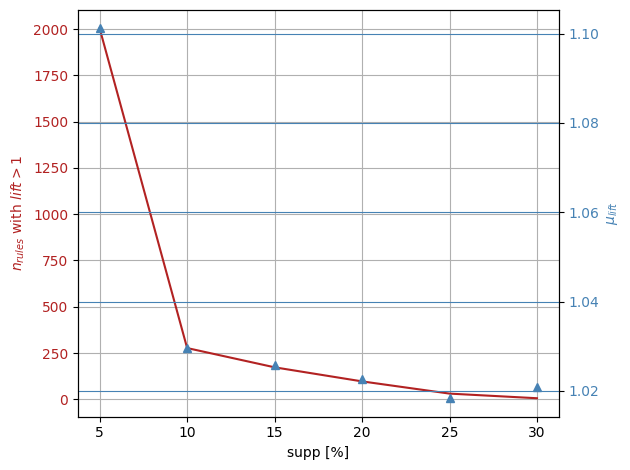

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()
ax1.grid()

ax1.set_xlabel('supp [%]')
ax1.set_ylabel(r'$n_{rules}$ with $lift > 1$',color='firebrick')
ax1.plot(min_supp_list, number_of_rules, color='firebrick',label=r'$n_{rules}$')
ax1.tick_params(axis='y', labelcolor='firebrick')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(color='steelblue')

ax2.set_ylabel(r'$\mu_{lift}$', color='steelblue')  # we already handled the x-label with ax1
ax2.errorbar(min_supp_list, mean_lift, color='steelblue', marker='^', linestyle='', label=r'$\mu_{lift}$')
ax2.tick_params(axis='y', labelcolor='steelblue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.legend()
plt.show()

Let's add third dimension: plotting number of rules with lift>1 in a colorgrid of confidence and support. 

In [35]:
len_r = []
mean_lift = []
min_sup = 5
max_sup = 20
min_conf = 50
max_conf = 90

for i in range(min_sup, max_sup):  # support
    len_r_wrt_i = []
    mean_lift_wrt_i = []
    for j in range(min_conf, max_conf):  # confidence
        rules = apriori(X, target="r", supp=i, zmin=zmin, conf=j, report="aScl")
        rules_df = pd.DataFrame(
        rules,
        columns=[
            "consequent",
            "antecedent",
            "abs_support",
            "%_support",
            "confidence",
            "lift",
        ],
    )
        mask = rules_df['lift'] > 1.0
        rules_masked = rules_df[mask]
        len_r_wrt_i.append(len(rules_masked))  # study your characteristics/properties here
        mean_lift_wrt_i.append(np.mean(rules_masked['lift']))

    len_r.append(len_r_wrt_i)
    mean_lift.append(mean_lift_wrt_i)
len_r = np.array(len_r)
mean_lift = np.array(mean_lift)

In [36]:
def heatmap_with_labels(column_vals: np.array, row_vals: np.array, heatmap_values : np.array, heatmap_annotations : np.array):

    #Saving the len of the columns and rows

    #Creating the custom colormap (it is useful if it is needed to customize it)
    my_cmap = plt.cm.get_cmap('Greens')
    column_number = len(column_vals)
    row_number = len(row_vals)
    #Plotting the map and make it pretty
    fig = plt.figure(figsize=(20,15))
    axes = plt.gca()
    plt.pcolormesh(heatmap_values, cmap=my_cmap, edgecolors='k', linewidths=1, shading='flat')
    # Loop over data dimensions and create text annotations.
    fmt = dict(ha='center', va='center', color='b')
    fmt2 = dict(ha='center', va='center', color='red')
    for i in range(row_number):
        for j in range(column_number):
            if heatmap_annotations[i, j] > 1.2:
                axes.text(j + 0.5, i + 0.5, f'{heatmap_annotations[i, j]:.2f}', **fmt2)
            else:
                axes.text(j + 0.5, i + 0.5, f'{heatmap_annotations[i, j]:.2f}', **fmt)
    axes.xaxis.set(ticks=np.arange(0.5, column_number), ticklabels=column_vals)
    axes.yaxis.set(ticks=np.arange(0.5, row_number), ticklabels=row_vals)
    fig.tight_layout()
    plt.colorbar() #plotting colorbar
    return fig, axes

/var/folders/j1/wdxl892j6_94fw1s4vcb534c0000gn/T/ipykernel_6743/4122478382.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = plt.cm.get_cmap('Greens')


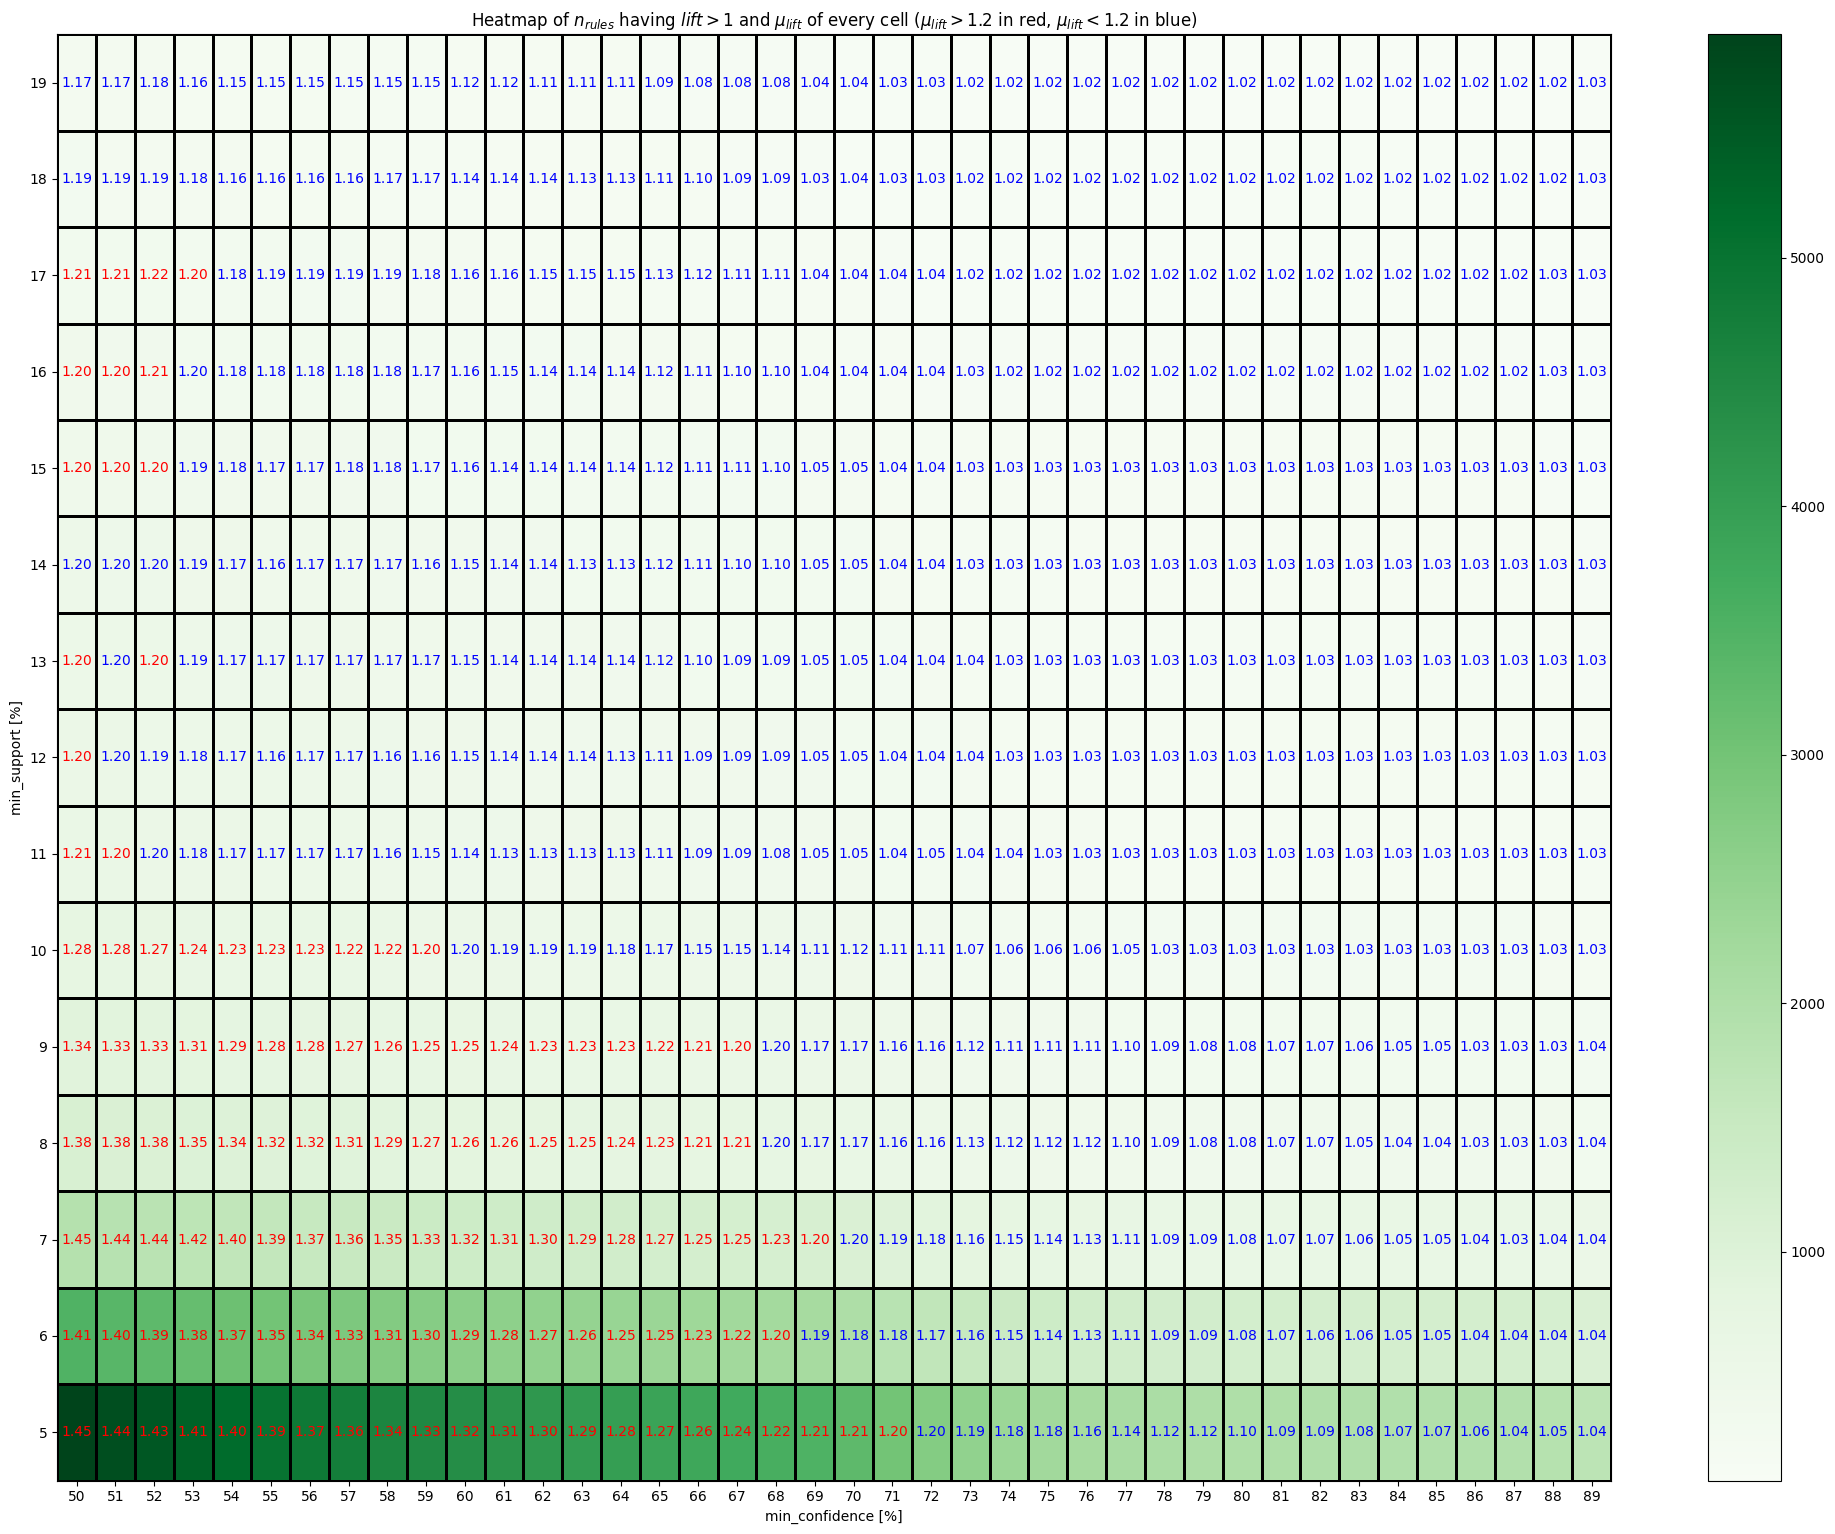

In [37]:

heatmap_with_labels(range(min_conf, max_conf), range(min_sup, max_sup), len_r, mean_lift)
plt.title(r'Heatmap of $n_{rules}$ having $lift > 1$ and $\mu_{lift}$ of every cell ($\mu_{lift} > 1.2$ in red, $\mu_{lift} < 1.2$ in blue)')
plt.xlabel('min_confidence [%]')
plt.ylabel('min_support [%]')
plt.show()

#### Classification and missing values 

Being a the missing values of the datasets relative to the two attributes `mode` and `time_signature`, we can search for rules regarding those ones in order to find a way of filling missing values more correctly. 

First thing to do re-upload dataset and cancel data with missing values, we will use only the ones with full informations in order to find solid rules. 

In [38]:
# importing dataset
df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified
df_test = pd.read_csv("dataset (missing + split)/test.csv", skipinitialspace=True)

In [39]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4
#Changing udm to duration_ms and features_duration_ms from ms to min - test
df_test['duration_ms'] *= 1/6e4
#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting popularity as a % - test
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

We drop anyway `popularity_confidence` by now bc it has very low counts. 

In [40]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats', 'loudness'] 
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

In [41]:
#dropping all rows having at least 1 NaN
df_train = df_train.dropna()

In [42]:
df_train

,duration_min,explicit,popularity_percent,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,4.029333,False,0.46,0.6900,0.51300,5,1.0,0.0975,0.302000,0.536000,0.2810,0.6350,142.221,4.0,j-dance
1,7.400000,False,0.00,0.0690,0.19600,1,0.0,0.0805,0.283000,0.934000,0.3600,0.0336,75.596,4.0,iranian
3,4.496667,False,0.23,0.5230,0.58500,5,1.0,0.0765,0.066400,0.001270,0.1170,0.3850,140.880,4.0,bluegrass
4,5.127517,False,0.25,0.6430,0.68700,7,1.0,0.0539,0.000576,0.096900,0.2990,0.6370,143.956,4.0,happy
6,3.752667,False,0.27,0.7770,0.94900,2,1.0,0.0585,0.306000,0.000016,0.2990,0.8500,109.992,4.0,j-idol
9,6.763333,False,0.21,0.3110,0.72900,4,1.0,0.0346,0.000116,0.222000,0.2250,0.1190,141.326,4.0,black-metal
10,3.188267,False,0.19,0.9240,0.89300,7,1.0,0.1910,0.016600,0.859000,0.0907,0.6130,129.999,4.0,j-dance
11,1.658767,False,0.21,0.8850,0.75000,6,0.0,0.1730,0.087800,0.963000,0.0453,0.4060,140.079,4.0,techno
12,3.638817,False,0.22,0.7920,0.85400,7,1.0,0.1050,0.116000,0.000004,0.1080,0.8290,110.010,4.0,j-dance
16,3.244133,False,0.57,0.1700,0.00316,5,0.0,0.0422,0.991000,0.931000,0.1110,0.0946,70.964,3.0,sleep


#### Encoding in order to use `apriori`

In [43]:
#bins the continuous attributes using quartile distribution
df_train["duration_min_bin"] = pd.qcut(df_train["duration_min"], 4)
df_train["popularity_percent_bin"] = pd.qcut(df_train["popularity_percent"], 4)
df_train["danceability_bin"] = pd.qcut(df_train["danceability"], 4)
df_train["energy_bin"] = pd.qcut(df_train["energy"], 4)
df_train["speechiness_bin"] = pd.qcut(df_train["speechiness"], 4)
df_train["acousticness_bin"] = pd.qcut(df_train["acousticness"], 4)
df_train["instrumentalness_bin"] = pd.qcut(df_train["instrumentalness"], 4, duplicates='drop')
df_train["liveness_bin"] = pd.qcut(df_train["liveness"], 4)
df_train["valence_bin"] = pd.qcut(df_train["valence"], 4)
df_train["tempo_bin"] = pd.qcut(df_train["tempo"], 4)

df_train.drop(["duration_min", "popularity_percent", "danceability", "energy", 
               "speechiness", "acousticness", "instrumentalness", 
               "liveness", "valence", "tempo"], axis=1, inplace=True)

In [44]:
df_train["duration_min_bin"] = df_train["duration_min_bin"].astype(str) + "_minutes"
df_train["popularity_percent_bin"] = df_train["popularity_percent_bin"].astype(str) + "_popularity"
df_train["danceability_bin"] = df_train["danceability_bin"].astype(str) + "_dance"
df_train["energy_bin"] = df_train["energy_bin"].astype(str) + "_energy"
df_train["speechiness_bin"] = df_train["speechiness_bin"].astype(str) + "_speech"
df_train["acousticness_bin"] = df_train["acousticness_bin"].astype(str) + "_acoustic"
df_train["instrumentalness_bin"] = df_train["instrumentalness_bin"].astype(str) + "_instru"
df_train["liveness_bin"] = df_train["liveness_bin"].astype(str) + "_liveness"
df_train["valence_bin"] = df_train["valence_bin"].astype(str) + "_valence"
df_train["tempo_bin"] = df_train["tempo_bin"].astype(str) + "_tempo"
df_train["mode"] = df_train["mode"].astype(str) + "_mode"



In [45]:
from sklearn.preprocessing import LabelEncoder

#### Encoding `explicit`

In [46]:
#just a trial, encoding the bool attribute `explicit`
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])

In [47]:
df_train

,explicit,key,mode,time_signature,genre,duration_min_bin,popularity_percent_bin,danceability_bin,energy_bin,speechiness_bin,acousticness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,0,5,1.0_mode,4.0,j-dance,"(3.793, 4.826]_minutes","(0.42, 0.94]_popularity","(0.58, 0.696]_dance","(0.477, 0.709]_energy","(0.0877, 0.939]_speech","(0.155, 0.573]_acoustic","(0.00335, 0.747]_instru","(0.278, 0.994]_liveness","(0.412, 0.663]_valence","(141.92, 220.084]_tempo"
1,0,1,0.0_mode,4.0,iranian,"(4.826, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(-0.001, 0.477]_energy","(0.0505, 0.0877]_speech","(0.155, 0.573]_acoustic","(0.747, 1.0]_instru","(0.278, 0.994]_liveness","(-0.001, 0.193]_valence","(-0.001, 99.889]_tempo"
3,0,5,1.0_mode,4.0,bluegrass,"(3.793, 4.826]_minutes","(0.14, 0.24]_popularity","(0.441, 0.58]_dance","(0.477, 0.709]_energy","(0.0505, 0.0877]_speech","(0.00961, 0.155]_acoustic","(-0.001, 0.00335]_instru","(0.0981, 0.131]_liveness","(0.193, 0.412]_valence","(124.316, 141.92]_tempo"
4,0,7,1.0_mode,4.0,happy,"(4.826, 68.671]_minutes","(0.24, 0.42]_popularity","(0.58, 0.696]_dance","(0.477, 0.709]_energy","(0.0505, 0.0877]_speech","(-0.001, 0.00961]_acoustic","(0.00335, 0.747]_instru","(0.278, 0.994]_liveness","(0.412, 0.663]_valence","(141.92, 220.084]_tempo"
6,0,2,1.0_mode,4.0,j-idol,"(2.996, 3.793]_minutes","(0.24, 0.42]_popularity","(0.696, 0.98]_dance","(0.884, 1.0]_energy","(0.0505, 0.0877]_speech","(0.155, 0.573]_acoustic","(-0.001, 0.00335]_instru","(0.278, 0.994]_liveness","(0.663, 0.995]_valence","(99.889, 124.316]_tempo"
9,0,4,1.0_mode,4.0,black-metal,"(4.826, 68.671]_minutes","(0.14, 0.24]_popularity","(-0.001, 0.441]_dance","(0.709, 0.884]_energy","(-0.001, 0.0372]_speech","(-0.001, 0.00961]_acoustic","(0.00335, 0.747]_instru","(0.131, 0.278]_liveness","(-0.001, 0.193]_valence","(124.316, 141.92]_tempo"
10,0,7,1.0_mode,4.0,j-dance,"(2.996, 3.793]_minutes","(0.14, 0.24]_popularity","(0.696, 0.98]_dance","(0.884, 1.0]_energy","(0.0877, 0.939]_speech","(0.00961, 0.155]_acoustic","(0.747, 1.0]_instru","(-0.001, 0.0981]_liveness","(0.412, 0.663]_valence","(124.316, 141.92]_tempo"
11,0,6,0.0_mode,4.0,techno,"(0.222, 2.996]_minutes","(0.14, 0.24]_popularity","(0.696, 0.98]_dance","(0.709, 0.884]_energy","(0.0877, 0.939]_speech","(0.00961, 0.155]_acoustic","(0.747, 1.0]_instru","(-0.001, 0.0981]_liveness","(0.193, 0.412]_valence","(124.316, 141.92]_tempo"
12,0,7,1.0_mode,4.0,j-dance,"(2.996, 3.793]_minutes","(0.14, 0.24]_popularity","(0.696, 0.98]_dance","(0.709, 0.884]_energy","(0.0877, 0.939]_speech","(0.00961, 0.155]_acoustic","(-0.001, 0.00335]_instru","(0.0981, 0.131]_liveness","(0.663, 0.995]_valence","(99.889, 124.316]_tempo"
16,0,5,0.0_mode,3.0,sleep,"(2.996, 3.793]_minutes","(0.42, 0.94]_popularity","(-0.001, 0.441]_dance","(-0.001, 0.477]_energy","(0.0372, 0.0505]_speech","(0.573, 0.996]_acoustic","(0.747, 1.0]_instru","(0.0981, 0.131]_liveness","(-0.001, 0.193]_valence","(-0.001, 99.889]_tempo"


Searching for min supp of `mode` and `time_signature` values. 

In [48]:
df_train['time_signature'].value_counts()

time_signature
4.0    7882
3.0     806
5.0     252
1.0     102
0.0      63
Name: count, dtype: int64

In [49]:
df_train['mode'].value_counts()

mode
1.0_mode    5768
0.0_mode    3337
Name: count, dtype: int64

In [50]:
X = df_train.values.tolist() #Apriori needs to work with a list not a np array

Searching for rules having as consequent `mode`. Dropping the idea of searching for `time_signature` bc it has very inhomogeneous support.  

In [51]:
supp = 10
conf = 70
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.25
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.min_rows', 20)
rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
rules_masked_df

,consequent,antecedent,abs_support,%_support,confidence,lift
122,"(-0.001, 0.477]_energy","((0.573, 0.996]_acoustic, (-0.001, 0.441]_dance)",767,8.423943,0.828294,3.306276
120,"(-0.001, 0.477]_energy","((0.573, 0.996]_acoustic, (-0.001, 0.441]_dance, 0)",765,8.401977,0.827922,3.304792
121,"(0.573, 0.996]_acoustic","((-0.001, 0.441]_dance, (-0.001, 0.477]_energy, 0)",765,8.401977,0.794393,3.179316
123,"(0.573, 0.996]_acoustic","((-0.001, 0.441]_dance, (-0.001, 0.477]_energy)",767,8.423943,0.793996,3.177728
125,"(-0.001, 0.477]_energy","((0.573, 0.996]_acoustic, (-0.001, 99.889]_tempo, 0)",730,8.017573,0.790043,3.153592
127,"(-0.001, 0.477]_energy","((0.573, 0.996]_acoustic, (-0.001, 99.889]_tempo)",735,8.072488,0.781915,3.121146
131,"(0.573, 0.996]_acoustic","((-0.001, 0.477]_energy, (-0.001, 0.193]_valence, 0)",731,8.028556,0.741379,2.967147
132,"(0.573, 0.996]_acoustic","((-0.001, 0.477]_energy, (-0.001, 0.193]_valence)",734,8.061505,0.737688,2.952375
133,"(0.573, 0.996]_acoustic","((-0.001, 0.477]_energy, (0.0981, 0.131]_liveness, 0)",691,7.589237,0.736674,2.948314
134,"(0.573, 0.996]_acoustic","((-0.001, 0.477]_energy, (0.0981, 0.131]_liveness)",696,7.644152,0.731092,2.925977


#### Searching for rules with consequent 0.0 mode or 1.0 mode. 

In [52]:
mode0_rules = rules_masked_df[rules_masked_df["consequent"] == "0.0_mode"]
mode1_rules = rules_masked_df[rules_masked_df["consequent"] == "1.0_mode"]

In [53]:
mode0_rules

,consequent,antecedent,abs_support,%_support,confidence,lift


In [54]:
mode1_rules

,consequent,antecedent,abs_support,%_support,confidence,lift
3,1.0_mode,"(7, 0)",821,9.017024,0.794773,1.254578
4,1.0_mode,"(7,)",873,9.588138,0.792916,1.251646


#### Searching for rules with consequent some value of the `time_signature`. 

In [55]:
mode0_rules = rules_masked_df[rules_masked_df["consequent"] == 0.0]
mode1_rules = rules_masked_df[rules_masked_df["consequent"] == 1.0]
mode3_rules = rules_masked_df[rules_masked_df["consequent"] == 3.0]
mode4_rules = rules_masked_df[rules_masked_df["consequent"] == 4.0]
mode5_rules = rules_masked_df[rules_masked_df["consequent"] == 5.0]

In [56]:
mode0_rules

,consequent,antecedent,abs_support,%_support,confidence,lift


In [57]:
mode1_rules

,consequent,antecedent,abs_support,%_support,confidence,lift


In [58]:
mode3_rules

,consequent,antecedent,abs_support,%_support,confidence,lift


In [59]:
mode4_rules

,consequent,antecedent,abs_support,%_support,confidence,lift


In [60]:
mode5_rules

,consequent,antecedent,abs_support,%_support,confidence,lift


We can use them but lift is not so promising.

#### Pattern mining for classification

In [61]:
# importing dataset
df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified
df_test = pd.read_csv("dataset (missing + split)/test.csv", skipinitialspace=True)

In [62]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4
#Changing udm to duration_ms and features_duration_ms from ms to min - test
df_test['duration_ms'] *= 1/6e4
#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting popularity as a % - test
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

### Filling of NaN values

In [63]:
#Dealing with mode attribute missing values - train
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
list_of_nan_indexes_train=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_train:
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0
        
#Dealing with mode attribute missing values - test
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_test['mode'].value_counts()[0]/(len(df_test)-df_test['mode'].isnull().sum())
p1=df_test['mode'].value_counts()[1]/(len(df_test)-df_test['mode'].isnull().sum())
list_of_nan_indexes_test=df_test[df_test['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_test:
    if np.random.random() < p1:
        df_test.loc[i,'mode'] = 1.0
    else:
        df_test.loc[i,'mode'] = 0.0

In [64]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]
    
#Dealing with time_signature attribute missing values - test
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_test['time_signature'].value_counts())
p_array=np.array(df_test['time_signature'].value_counts().sort_index(ascending=True)/(len(df_test)-df_test['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_test[df_test['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_test.loc[i,'time_signature'] = dict_ts[index]

Let's check if everything is fine

In [65]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [66]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature              0
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [67]:
df_train['genre'].value_counts()

genre
j-dance          750
iranian          750
brazil           750
chicago-house    750
forro            750
idm              750
indian           750
study            750
disney           750
afrobeat         750
mandopop         750
techno           750
sleep            750
spanish          750
j-idol           750
industrial       750
happy            750
bluegrass        750
black-metal      750
breakbeat        750
Name: count, dtype: int64

In [68]:
df_test['genre'].value_counts()

genre
industrial       250
breakbeat        250
happy            250
afrobeat         250
study            250
black-metal      250
sleep            250
bluegrass        250
techno           250
brazil           250
j-dance          250
chicago-house    250
disney           250
iranian          250
mandopop         250
idm              250
spanish          250
j-idol           250
indian           250
forro            250
Name: count, dtype: int64

### Encoding `str` values - creating the various `genre` maps
- first map: 20 classes, one for every genre;
- second map: regrouping per macro genre with the following labels:  

| Label | Macro genre | `genre` list |
| ----------- | ----------- | -------------------------------------------------------------|
| 0 | Electronic | `breakbeat`, `chicago house`, `techno`, `afrobeat`, `idm` , `industrial`|
| 1 | Pop + Asian| `mandopop`,`j-idol`,`happy`,`disney`,`j-dance`, `indian`|
| 2 | Latin | `forro`,`brazil`,`spanish`|
| 3 | Country | `bluegrass`|
| 4 | Metal | `black metal`|
| 5 | Iranian | `iranian`|
| 6 | Others | `sleep`, `study`|

In [69]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values. 
#genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":1,"iranian":5,"brazil":2,"chicago-house":0,"forro":2,"idm":0,"indian":1,"study":6,"disney":1,"afrobeat":0,"mandopop":1,"techno":0,"sleep":6,"spanish":2,"j-idol":1,"industrial":0,"happy":1,"bluegrass":3,"black-metal":4,"breakbeat":0}

#aa

In [70]:
df_train.replace({'genre':macrogenre_map}, inplace=True)
df_test.replace({'genre':macrogenre_map}, inplace=True)

#### Encoding in order to use `apriori`

In [71]:
#bins the continuous attributes using quartile distribution
df_train["duration_min_bin"] = pd.qcut(df_train["duration_min"], 4)
df_train["popularity_percent_bin"] = pd.qcut(df_train["popularity_percent"], 4)
df_train["danceability_bin"] = pd.qcut(df_train["danceability"], 4)
df_train["energy_bin"] = pd.qcut(df_train["energy"], 4)
df_train["speechiness_bin"] = pd.qcut(df_train["speechiness"], 4)
df_train["acousticness_bin"] = pd.qcut(df_train["acousticness"], 4)
df_train["instrumentalness_bin"] = pd.qcut(df_train["instrumentalness"], 4, duplicates='drop')
df_train["liveness_bin"] = pd.qcut(df_train["liveness"], 4)
df_train["valence_bin"] = pd.qcut(df_train["valence"], 4)
df_train["tempo_bin"] = pd.qcut(df_train["tempo"], 4)

df_train.drop(["duration_min", "popularity_percent", "danceability", "energy",
              "speechiness", "acousticness", "instrumentalness", 
               "liveness", "valence", "tempo"], axis=1, inplace=True)

In [72]:
df_train["duration_min_bin"] = df_train["duration_min_bin"].astype(str) + "_minutes"
df_train["popularity_percent_bin"] = df_train["popularity_percent_bin"].astype(str) + "_popularity"
df_train["danceability_bin"] = df_train["danceability_bin"].astype(str) + "_dance"
df_train["energy_bin"] = df_train["energy_bin"].astype(str) + "_energy"
df_train["speechiness_bin"] = df_train["speechiness_bin"].astype(str) + "_speech"
df_train["acousticness_bin"] = df_train["acousticness_bin"].astype(str) + "_acoustic"
df_train["instrumentalness_bin"] = df_train["instrumentalness_bin"].astype(str) + "_instru"
df_train["liveness_bin"] = df_train["liveness_bin"].astype(str) + "_liveness"
df_train["valence_bin"] = df_train["valence_bin"].astype(str) + "_valence"
df_train["tempo_bin"] = df_train["tempo_bin"].astype(str) + "_tempo"
df_train["mode"] = df_train["mode"].astype(str) + "_mode"
df_train["time_signature"] = df_train["time_signature"].astype(str) + "_timesig"



#### Encoding `explicit`

In [73]:
#just a trial, encoding the bool attribute `explicit`
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])
df_test['explicit'] = le.fit_transform(df_test['explicit'])

df_train["explicit"] = df_train["explicit"].astype(str) + "_expl"
df_test["explicit"] = df_test["explicit"].astype(str) + "_expl"

In [74]:
#bins the continuous attributes using quartile distribution
df_test["duration_min_bin"] = pd.qcut(df_test["duration_min"], 4)
df_test["popularity_percent_bin"] = pd.qcut(df_test["popularity_percent"], 4)
df_test["danceability_bin"] = pd.qcut(df_test["danceability"], 4)
df_test["energy_bin"] = pd.qcut(df_test["energy"], 4)
df_test["speechiness_bin"] = pd.qcut(df_test["speechiness"], 4)
df_test["acousticness_bin"] = pd.qcut(df_test["acousticness"], 4)
df_test["instrumentalness_bin"] = pd.qcut(df_test["instrumentalness"], 4, duplicates='drop')
df_test["liveness_bin"] = pd.qcut(df_test["liveness"], 4)
df_test["valence_bin"] = pd.qcut(df_test["valence"], 4)
df_test["tempo_bin"] = pd.qcut(df_test["tempo"], 4)

df_test.drop(["duration_min", "popularity_percent", "danceability", "energy",
               "speechiness", "acousticness", "instrumentalness", 
               "liveness", "valence", "tempo"], axis=1, inplace=True)

In [75]:
df_test["duration_min_bin"] = df_test["duration_min_bin"].astype(str) + "_minutes"
df_test["popularity_percent_bin"] = df_test["popularity_percent_bin"].astype(str) + "_popularity"
df_test["danceability_bin"] = df_test["danceability_bin"].astype(str) + "_dance"
df_test["energy_bin"] = df_test["energy_bin"].astype(str) + "_energy"
df_test["speechiness_bin"] = df_test["speechiness_bin"].astype(str) + "_speech"
df_test["acousticness_bin"] = df_test["acousticness_bin"].astype(str) + "_acoustic"
df_test["instrumentalness_bin"] = df_test["instrumentalness_bin"].astype(str) + "_instru"
df_test["liveness_bin"] = df_test["liveness_bin"].astype(str) + "_liveness"
df_test["valence_bin"] = df_test["valence_bin"].astype(str) + "_valence"
df_test["tempo_bin"] = df_test["tempo_bin"].astype(str) + "_tempo"
df_test["mode"] = df_test["mode"].astype(str) + "_mode"
df_test["time_signature"] = df_test["time_signature"].astype(str) + "_timesig"




In [76]:
df_train.head()

,name,explicit,artists,album_name,key,loudness,mode,features_duration_ms,time_signature,n_beats,...,duration_min_bin,popularity_percent_bin,danceability_bin,energy_bin,speechiness_bin,acousticness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,Long Road,0_expl,Funki Porcini,Hed Phone Sex,5,-12.529,1.0_mode,241760,4.0_timesig,567.0,...,"(3.797, 4.815]_minutes","(0.42, 0.94]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(0.0886, 0.939]_speech","(0.155, 0.573]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"
1,"Daniâl My Son, Where Did You Vanish?",0_expl,Siavash Amini,A Trail of Laughters,1,-24.801,0.0_mode,444000,4.0_timesig,617.0,...,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(-0.001, 0.48]_energy","(0.051, 0.0886]_speech","(0.155, 0.573]_acoustic","(0.744, 1.0]_instru","(0.28, 0.994]_liveness","(-0.001, 0.196]_valence","(-0.001, 99.939]_tempo"
2,Ondskapens Galakse,0_expl,Kvelertak,Nattesferd,2,-7.445,1.0_mode,333507,4.0_timesig,652.0,...,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(0.709, 0.884]_energy","(0.0373, 0.051]_speech","(-0.001, 0.00974]_acoustic","(0.744, 1.0]_instru","(0.131, 0.28]_liveness","(0.416, 0.664]_valence","(99.939, 124.188]_tempo"
3,Can't Look Away,0_expl,The Wood Brothers,One Drop of Truth,5,-5.607,1.0_mode,269800,4.0_timesig,619.0,...,"(3.797, 4.815]_minutes","(0.14, 0.24]_popularity","(0.441, 0.58]_dance","(0.48, 0.709]_energy","(0.051, 0.0886]_speech","(0.00974, 0.155]_acoustic","(-0.001, 0.00313]_instru","(0.0979, 0.131]_liveness","(0.196, 0.416]_valence","(124.188, 141.986]_tempo"
4,Thunderground,0_expl,The Darkraver;DJ Vince,Happy Hardcore Top 100,7,-11.340,1.0_mode,307652,4.0_timesig,733.0,...,"(4.815, 68.671]_minutes","(0.24, 0.42]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(0.051, 0.0886]_speech","(-0.001, 0.00974]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"


In [77]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats', 'loudness'] 
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

In [78]:
df_train

,explicit,key,mode,time_signature,genre,duration_min_bin,popularity_percent_bin,danceability_bin,energy_bin,speechiness_bin,acousticness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,0_expl,5,1.0_mode,4.0_timesig,1,"(3.797, 4.815]_minutes","(0.42, 0.94]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(0.0886, 0.939]_speech","(0.155, 0.573]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"
1,0_expl,1,0.0_mode,4.0_timesig,5,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(-0.001, 0.48]_energy","(0.051, 0.0886]_speech","(0.155, 0.573]_acoustic","(0.744, 1.0]_instru","(0.28, 0.994]_liveness","(-0.001, 0.196]_valence","(-0.001, 99.939]_tempo"
2,0_expl,2,1.0_mode,4.0_timesig,4,"(4.815, 68.671]_minutes","(-0.001, 0.14]_popularity","(-0.001, 0.441]_dance","(0.709, 0.884]_energy","(0.0373, 0.051]_speech","(-0.001, 0.00974]_acoustic","(0.744, 1.0]_instru","(0.131, 0.28]_liveness","(0.416, 0.664]_valence","(99.939, 124.188]_tempo"
3,0_expl,5,1.0_mode,4.0_timesig,3,"(3.797, 4.815]_minutes","(0.14, 0.24]_popularity","(0.441, 0.58]_dance","(0.48, 0.709]_energy","(0.051, 0.0886]_speech","(0.00974, 0.155]_acoustic","(-0.001, 0.00313]_instru","(0.0979, 0.131]_liveness","(0.196, 0.416]_valence","(124.188, 141.986]_tempo"
4,0_expl,7,1.0_mode,4.0_timesig,1,"(4.815, 68.671]_minutes","(0.24, 0.42]_popularity","(0.58, 0.695]_dance","(0.48, 0.709]_energy","(0.051, 0.0886]_speech","(-0.001, 0.00974]_acoustic","(0.00313, 0.744]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"
5,1_expl,5,0.0_mode,4.0_timesig,0,"(3.0, 3.797]_minutes","(0.24, 0.42]_popularity","(0.58, 0.695]_dance","(0.884, 1.0]_energy","(0.0886, 0.939]_speech","(-0.001, 0.00974]_acoustic","(-0.001, 0.00313]_instru","(0.28, 0.994]_liveness","(0.416, 0.664]_valence","(99.939, 124.188]_tempo"
6,0_expl,2,1.0_mode,4.0_timesig,1,"(3.0, 3.797]_minutes","(0.24, 0.42]_popularity","(0.695, 0.98]_dance","(0.884, 1.0]_energy","(0.051, 0.0886]_speech","(0.155, 0.573]_acoustic","(-0.001, 0.00313]_instru","(0.28, 0.994]_liveness","(0.664, 0.995]_valence","(99.939, 124.188]_tempo"
7,0_expl,4,1.0_mode,4.0_timesig,2,"(3.0, 3.797]_minutes","(0.42, 0.94]_popularity","(0.695, 0.98]_dance","(0.709, 0.884]_energy","(0.051, 0.0886]_speech","(0.00974, 0.155]_acoustic","(-0.001, 0.00313]_instru","(0.0979, 0.131]_liveness","(0.416, 0.664]_valence","(141.986, 220.525]_tempo"
8,0_expl,6,1.0_mode,4.0_timesig,6,"(0.142, 3.0]_minutes","(0.42, 0.94]_popularity","(-0.001, 0.441]_dance","(-0.001, 0.48]_energy","(0.0373, 0.051]_speech","(0.573, 0.996]_acoustic","(0.744, 1.0]_instru","(0.28, 0.994]_liveness","(-0.001, 0.196]_valence","(-0.001, 99.939]_tempo"
9,0_expl,4,1.0_mode,4.0_timesig,4,"(4.815, 68.671]_minutes","(0.14, 0.24]_popularity","(-0.001, 0.441]_dance","(0.709, 0.884]_energy","(-0.001, 0.0373]_speech","(-0.001, 0.00974]_acoustic","(0.00313, 0.744]_instru","(0.131, 0.28]_liveness","(-0.001, 0.196]_valence","(124.188, 141.986]_tempo"


In [79]:
df_test

,explicit,key,mode,time_signature,genre,duration_min_bin,popularity_percent_bin,danceability_bin,energy_bin,speechiness_bin,acousticness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,0_expl,0,1.0_mode,4.0_timesig,0,"(3.01, 3.842]_minutes","(0.25, 0.42]_popularity","(-0.001, 0.438]_dance","(0.879, 1.0]_energy","(0.0865, 0.943]_speech","(-0.001, 0.0093]_acoustic","(-0.001, 0.00351]_instru","(0.13, 0.282]_liveness","(0.661, 0.983]_valence","(99.998, 124.036]_tempo"
1,0_expl,5,1.0_mode,4.0_timesig,0,"(4.833, 60.002]_minutes","(0.25, 0.42]_popularity","(0.438, 0.574]_dance","(0.468, 0.702]_energy","(0.0504, 0.0865]_speech","(0.157, 0.581]_acoustic","(0.735, 1.0]_instru","(0.0969, 0.13]_liveness","(-0.001, 0.196]_valence","(142.028, 220.081]_tempo"
2,0_expl,9,1.0_mode,4.0_timesig,1,"(0.41, 3.01]_minutes","(0.25, 0.42]_popularity","(0.574, 0.696]_dance","(0.702, 0.879]_energy","(-0.001, 0.0365]_speech","(0.0093, 0.157]_acoustic","(-0.001, 0.00351]_instru","(0.13, 0.282]_liveness","(0.196, 0.402]_valence","(-0.001, 99.998]_tempo"
3,0_expl,0,0.0_mode,4.0_timesig,1,"(3.842, 4.833]_minutes","(0.14, 0.25]_popularity","(0.438, 0.574]_dance","(0.879, 1.0]_energy","(-0.001, 0.0365]_speech","(-0.001, 0.0093]_acoustic","(0.00351, 0.735]_instru","(0.282, 0.992]_liveness","(0.661, 0.983]_valence","(124.036, 142.028]_tempo"
4,0_expl,1,1.0_mode,4.0_timesig,0,"(3.01, 3.842]_minutes","(-0.001, 0.14]_popularity","(0.696, 0.975]_dance","(0.468, 0.702]_energy","(0.0865, 0.943]_speech","(-0.001, 0.0093]_acoustic","(0.00351, 0.735]_instru","(0.13, 0.282]_liveness","(0.402, 0.661]_valence","(124.036, 142.028]_tempo"
5,0_expl,10,0.0_mode,5.0_timesig,2,"(3.842, 4.833]_minutes","(0.25, 0.42]_popularity","(0.574, 0.696]_dance","(0.702, 0.879]_energy","(0.0504, 0.0865]_speech","(0.0093, 0.157]_acoustic","(-0.001, 0.00351]_instru","(-0.001, 0.0969]_liveness","(0.402, 0.661]_valence","(99.998, 124.036]_tempo"
6,0_expl,2,1.0_mode,3.0_timesig,0,"(0.41, 3.01]_minutes","(-0.001, 0.14]_popularity","(0.438, 0.574]_dance","(-0.0009805, 0.468]_energy","(0.0365, 0.0504]_speech","(0.581, 0.996]_acoustic","(0.00351, 0.735]_instru","(-0.001, 0.0969]_liveness","(-0.001, 0.196]_valence","(-0.001, 99.998]_tempo"
7,0_expl,2,0.0_mode,4.0_timesig,0,"(4.833, 60.002]_minutes","(0.25, 0.42]_popularity","(0.438, 0.574]_dance","(-0.0009805, 0.468]_energy","(-0.001, 0.0365]_speech","(0.581, 0.996]_acoustic","(0.735, 1.0]_instru","(-0.001, 0.0969]_liveness","(0.196, 0.402]_valence","(142.028, 220.081]_tempo"
8,0_expl,1,1.0_mode,4.0_timesig,1,"(3.842, 4.833]_minutes","(0.42, 0.89]_popularity","(0.438, 0.574]_dance","(-0.0009805, 0.468]_energy","(-0.001, 0.0365]_speech","(0.157, 0.581]_acoustic","(-0.001, 0.00351]_instru","(0.13, 0.282]_liveness","(0.196, 0.402]_valence","(124.036, 142.028]_tempo"
9,1_expl,5,1.0_mode,4.0_timesig,0,"(3.01, 3.842]_minutes","(-0.001, 0.14]_popularity","(0.438, 0.574]_dance","(0.879, 1.0]_energy","(0.0865, 0.943]_speech","(-0.001, 0.0093]_acoustic","(-0.001, 0.00351]_instru","(-0.001, 0.0969]_liveness","(-0.001, 0.196]_valence","(124.036, 142.028]_tempo"


Searching for some rule considering consequent `genre`. Doing that on train set and if it works using that for test set. 

In [80]:
X = df_train.values.tolist() #Apriori needs to work with a list not a np array

In [81]:
X

[['0_expl',
  5,
  '1.0_mode',
  '4.0_timesig',
  1,
  '(3.797, 4.815]_minutes',
  '(0.42, 0.94]_popularity',
  '(0.58, 0.695]_dance',
  '(0.48, 0.709]_energy',
  '(0.0886, 0.939]_speech',
  '(0.155, 0.573]_acoustic',
  '(0.00313, 0.744]_instru',
  '(0.28, 0.994]_liveness',
  '(0.416, 0.664]_valence',
  '(141.986, 220.525]_tempo'],
 ['0_expl',
  1,
  '0.0_mode',
  '4.0_timesig',
  5,
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(-0.001, 0.48]_energy',
  '(0.051, 0.0886]_speech',
  '(0.155, 0.573]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.28, 0.994]_liveness',
  '(-0.001, 0.196]_valence',
  '(-0.001, 99.939]_tempo'],
 ['0_expl',
  2,
  '1.0_mode',
  '4.0_timesig',
  4,
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(0.709, 0.884]_energy',
  '(0.0373, 0.051]_speech',
  '(-0.001, 0.00974]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.131, 0.28]_liveness',
  '(0.416, 0.664]_valence',
  '(99.939, 124.188]_te

In [82]:
supp = 5
conf = 60
rules = apriori(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl", eval = "lift")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
mask_rules = rules_df['lift'] > 1.
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.min_rows', 20)
rules_masked_df = rules_df[mask_rules].sort_values(by="lift", axis=0, ascending=False)
rules_masked_df

,consequent,antecedent,abs_support,%_support,confidence,lift
151,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, (-0.001, 0.48]_energy, 0_expl)",538,3.586667,0.659314,3.973365
154,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, (-0.001, 0.48]_energy)",538,3.586667,0.658507,3.968502
169,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, 0_expl)",809,5.393333,0.613809,3.699129
172,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes)",809,5.393333,0.611027,3.682366
187,6,"((-0.001, 99.939]_tempo, (0.142, 3.0]_minutes, (-0.001, 0.48]_energy)",460,3.066667,0.610080,3.676655
161,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, 4.0_timesig, 0_expl)",589,3.926667,0.608471,3.666961
165,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, 4.0_timesig)",589,3.926667,0.605344,3.648117
4842,"(-0.001, 0.196]_valence","((0.744, 1.0]_instru, (-0.001, 0.48]_energy, (-0.001, 0.441]_dance)",722,4.813333,0.882641,3.523047
4838,"(-0.001, 0.196]_valence","((0.744, 1.0]_instru, (-0.001, 0.48]_energy, (-0.001, 0.441]_dance, 0_expl)",719,4.793333,0.882209,3.521322
3935,"(-0.001, 0.48]_energy","((0.573, 0.996]_acoustic, (-0.001, 0.196]_valence, 1.0_mode, 0_expl)",766,5.106667,0.873432,3.485364


In [83]:
genre0_rules = rules_masked_df[rules_masked_df["consequent"] == 0]
genre1_rules = rules_masked_df[rules_masked_df["consequent"] == 1]
genre2_rules = rules_masked_df[rules_masked_df["consequent"] == 2]
genre3_rules = rules_masked_df[rules_masked_df["consequent"] == 3]
genre4_rules = rules_masked_df[rules_masked_df["consequent"] == 4]
genre5_rules = rules_masked_df[rules_masked_df["consequent"] == 5]
genre6_rules = rules_masked_df[rules_masked_df["consequent"] == 6]

In [84]:
genre0_rules

,consequent,antecedent,abs_support,%_support,confidence,lift
1833,0,"((0.695, 0.98]_dance, (4.815, 68.671]_minutes, 4.0_timesig, 0_expl)",810,5.400000,0.893054,2.317213
1856,0,"((0.695, 0.98]_dance, (-0.001, 0.00974]_acoustic, 4.0_timesig, 0_expl)",704,4.693333,0.892269,2.315176
1837,0,"((0.695, 0.98]_dance, (4.815, 68.671]_minutes, 0_expl)",846,5.640000,0.890526,2.310655
1858,0,"((0.695, 0.98]_dance, (-0.001, 0.00974]_acoustic, 4.0_timesig)",728,4.853333,0.889976,2.309226
1860,0,"((0.695, 0.98]_dance, (-0.001, 0.00974]_acoustic, 0_expl)",727,4.846667,0.889841,2.308876
1861,0,"((0.695, 0.98]_dance, (-0.001, 0.00974]_acoustic)",753,5.020000,0.886926,2.301312
1835,0,"((0.695, 0.98]_dance, (4.815, 68.671]_minutes, 4.0_timesig)",822,5.480000,0.880086,2.283564
1838,0,"((0.695, 0.98]_dance, (4.815, 68.671]_minutes)",859,5.726667,0.878323,2.278991
1874,0,"((0.695, 0.98]_dance, (0.00313, 0.744]_instru, 4.0_timesig, 0_expl)",613,4.086667,0.761491,1.975845
1875,0,"((0.695, 0.98]_dance, (0.00313, 0.744]_instru, 4.0_timesig)",637,4.246667,0.753846,1.956010


In [85]:
genre1_rules

,consequent,antecedent,abs_support,%_support,confidence,lift
901,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru, 1.0_mode)",678,4.520000,0.637817,1.707525
899,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru, 1.0_mode, 0_expl)",600,4.000000,0.630915,1.689046
897,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru, 1.0_mode, 4.0_timesig)",589,3.926667,0.630621,1.688259
909,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru)",1018,6.786667,0.629172,1.684379
895,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru, 1.0_mode, 4.0_timesig, 0_expl)",531,3.540000,0.627660,1.680331
4373,1,"((0.0886, 0.939]_speech, (0.00974, 0.155]_acoustic, (-0.001, 0.00313]_instru)",476,3.173333,0.626316,1.676733
906,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru, 4.0_timesig)",882,5.880000,0.621127,1.662842
908,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru, 0_expl)",877,5.846667,0.614576,1.645304
904,1,"((0.14, 0.24]_popularity, (-0.001, 0.00313]_instru, 4.0_timesig, 0_expl)",776,5.173333,0.611024,1.635794
5482,1,"((3.797, 4.815]_minutes, (0.441, 0.58]_dance, (-0.001, 0.00313]_instru, 4.0_timesig, 0_expl)",474,3.160000,0.610039,1.633157


In [86]:
genre2_rules


,consequent,antecedent,abs_support,%_support,confidence,lift


In [87]:
genre3_rules


,consequent,antecedent,abs_support,%_support,confidence,lift


In [88]:
genre4_rules


,consequent,antecedent,abs_support,%_support,confidence,lift


In [89]:
genre5_rules


,consequent,antecedent,abs_support,%_support,confidence,lift


In [90]:
genre6_rules


,consequent,antecedent,abs_support,%_support,confidence,lift
151,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, (-0.001, 0.48]_energy, 0_expl)",538,3.586667,0.659314,3.973365
154,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, (-0.001, 0.48]_energy)",538,3.586667,0.658507,3.968502
169,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, 0_expl)",809,5.393333,0.613809,3.699129
172,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes)",809,5.393333,0.611027,3.682366
187,6,"((-0.001, 99.939]_tempo, (0.142, 3.0]_minutes, (-0.001, 0.48]_energy)",460,3.066667,0.610080,3.676655
161,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, 4.0_timesig, 0_expl)",589,3.926667,0.608471,3.666961
165,6,"((0.744, 1.0]_instru, (0.142, 3.0]_minutes, 4.0_timesig)",589,3.926667,0.605344,3.648117


In [91]:
750/15000


0.05

In [92]:
df_test

,explicit,key,mode,time_signature,genre,duration_min_bin,popularity_percent_bin,danceability_bin,energy_bin,speechiness_bin,acousticness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,0_expl,0,1.0_mode,4.0_timesig,0,"(3.01, 3.842]_minutes","(0.25, 0.42]_popularity","(-0.001, 0.438]_dance","(0.879, 1.0]_energy","(0.0865, 0.943]_speech","(-0.001, 0.0093]_acoustic","(-0.001, 0.00351]_instru","(0.13, 0.282]_liveness","(0.661, 0.983]_valence","(99.998, 124.036]_tempo"
1,0_expl,5,1.0_mode,4.0_timesig,0,"(4.833, 60.002]_minutes","(0.25, 0.42]_popularity","(0.438, 0.574]_dance","(0.468, 0.702]_energy","(0.0504, 0.0865]_speech","(0.157, 0.581]_acoustic","(0.735, 1.0]_instru","(0.0969, 0.13]_liveness","(-0.001, 0.196]_valence","(142.028, 220.081]_tempo"
2,0_expl,9,1.0_mode,4.0_timesig,1,"(0.41, 3.01]_minutes","(0.25, 0.42]_popularity","(0.574, 0.696]_dance","(0.702, 0.879]_energy","(-0.001, 0.0365]_speech","(0.0093, 0.157]_acoustic","(-0.001, 0.00351]_instru","(0.13, 0.282]_liveness","(0.196, 0.402]_valence","(-0.001, 99.998]_tempo"
3,0_expl,0,0.0_mode,4.0_timesig,1,"(3.842, 4.833]_minutes","(0.14, 0.25]_popularity","(0.438, 0.574]_dance","(0.879, 1.0]_energy","(-0.001, 0.0365]_speech","(-0.001, 0.0093]_acoustic","(0.00351, 0.735]_instru","(0.282, 0.992]_liveness","(0.661, 0.983]_valence","(124.036, 142.028]_tempo"
4,0_expl,1,1.0_mode,4.0_timesig,0,"(3.01, 3.842]_minutes","(-0.001, 0.14]_popularity","(0.696, 0.975]_dance","(0.468, 0.702]_energy","(0.0865, 0.943]_speech","(-0.001, 0.0093]_acoustic","(0.00351, 0.735]_instru","(0.13, 0.282]_liveness","(0.402, 0.661]_valence","(124.036, 142.028]_tempo"
5,0_expl,10,0.0_mode,5.0_timesig,2,"(3.842, 4.833]_minutes","(0.25, 0.42]_popularity","(0.574, 0.696]_dance","(0.702, 0.879]_energy","(0.0504, 0.0865]_speech","(0.0093, 0.157]_acoustic","(-0.001, 0.00351]_instru","(-0.001, 0.0969]_liveness","(0.402, 0.661]_valence","(99.998, 124.036]_tempo"
6,0_expl,2,1.0_mode,3.0_timesig,0,"(0.41, 3.01]_minutes","(-0.001, 0.14]_popularity","(0.438, 0.574]_dance","(-0.0009805, 0.468]_energy","(0.0365, 0.0504]_speech","(0.581, 0.996]_acoustic","(0.00351, 0.735]_instru","(-0.001, 0.0969]_liveness","(-0.001, 0.196]_valence","(-0.001, 99.998]_tempo"
7,0_expl,2,0.0_mode,4.0_timesig,0,"(4.833, 60.002]_minutes","(0.25, 0.42]_popularity","(0.438, 0.574]_dance","(-0.0009805, 0.468]_energy","(-0.001, 0.0365]_speech","(0.581, 0.996]_acoustic","(0.735, 1.0]_instru","(-0.001, 0.0969]_liveness","(0.196, 0.402]_valence","(142.028, 220.081]_tempo"
8,0_expl,1,1.0_mode,4.0_timesig,1,"(3.842, 4.833]_minutes","(0.42, 0.89]_popularity","(0.438, 0.574]_dance","(-0.0009805, 0.468]_energy","(-0.001, 0.0365]_speech","(0.157, 0.581]_acoustic","(-0.001, 0.00351]_instru","(0.13, 0.282]_liveness","(0.196, 0.402]_valence","(124.036, 142.028]_tempo"
9,1_expl,5,1.0_mode,4.0_timesig,0,"(3.01, 3.842]_minutes","(-0.001, 0.14]_popularity","(0.438, 0.574]_dance","(0.879, 1.0]_energy","(0.0865, 0.943]_speech","(-0.001, 0.0093]_acoustic","(-0.001, 0.00351]_instru","(-0.001, 0.0969]_liveness","(-0.001, 0.196]_valence","(124.036, 142.028]_tempo"


In [93]:
X

[['0_expl',
  5,
  '1.0_mode',
  '4.0_timesig',
  1,
  '(3.797, 4.815]_minutes',
  '(0.42, 0.94]_popularity',
  '(0.58, 0.695]_dance',
  '(0.48, 0.709]_energy',
  '(0.0886, 0.939]_speech',
  '(0.155, 0.573]_acoustic',
  '(0.00313, 0.744]_instru',
  '(0.28, 0.994]_liveness',
  '(0.416, 0.664]_valence',
  '(141.986, 220.525]_tempo'],
 ['0_expl',
  1,
  '0.0_mode',
  '4.0_timesig',
  5,
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(-0.001, 0.48]_energy',
  '(0.051, 0.0886]_speech',
  '(0.155, 0.573]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.28, 0.994]_liveness',
  '(-0.001, 0.196]_valence',
  '(-0.001, 99.939]_tempo'],
 ['0_expl',
  2,
  '1.0_mode',
  '4.0_timesig',
  4,
  '(4.815, 68.671]_minutes',
  '(-0.001, 0.14]_popularity',
  '(-0.001, 0.441]_dance',
  '(0.709, 0.884]_energy',
  '(0.0373, 0.051]_speech',
  '(-0.001, 0.00974]_acoustic',
  '(0.744, 1.0]_instru',
  '(0.131, 0.28]_liveness',
  '(0.416, 0.664]_valence',
  '(99.939, 124.188]_te

#### Classification trial for genra that have rules

We try to classify macrogenra 0,1,6 that have classification rules (some of then not so interesting).

0	((-0.001, 0.00974]_acoustic, (0.695, 0.98]_dance)	753	5.020000	0.886926	2.266420  
1   ((-5.101, 3.156]_dB, (0.00974, 0.155]_acoustic, (-0.001, 0.00313]_instru)	638	4.253333	0.640562	1.683328
6	((0.744, 1.0]_instru, (0.142, 3.0]_minutes, (-0.001, 0.48]_energy, 0_expl)	538	3.586667	0.659314	3.973365

In [94]:
def classification_using_rules(dataset : list) -> list:
    y_pred = []
    for i in dataset:
        if (i[7] == '(0.695, 0.98]_dance') & (i[10] == '(-0.001, 0.00974]_acoustic'):
            y_pred.append(0)
        elif (i[6] == '(0.14, 0.24]_popularity') & (i[2] == '1.0_mode') & (i[11] == '(-0.001, 0.00313]_instru'):
            y_pred.append(1)
        elif (i[11] == '(0.744, 1.0]_instru') & (i[5] == '(0.142, 3.0]_minutes') & (i[8] == '(-0.001, 0.48]_energy'):
            y_pred.append(6)
        else:
            y_pred.append(-1)
    return y_pred
    

In [95]:
tmp = df_train[(df_train['genre'] == 0) | (df_train['genre'] == 1) | (df_train['genre'] == 6)]

In [96]:
tmp_list = tmp.values.tolist()

In [97]:
tmp_list

[['0_expl',
  5,
  '1.0_mode',
  '4.0_timesig',
  1,
  '(3.797, 4.815]_minutes',
  '(0.42, 0.94]_popularity',
  '(0.58, 0.695]_dance',
  '(0.48, 0.709]_energy',
  '(0.0886, 0.939]_speech',
  '(0.155, 0.573]_acoustic',
  '(0.00313, 0.744]_instru',
  '(0.28, 0.994]_liveness',
  '(0.416, 0.664]_valence',
  '(141.986, 220.525]_tempo'],
 ['0_expl',
  7,
  '1.0_mode',
  '4.0_timesig',
  1,
  '(4.815, 68.671]_minutes',
  '(0.24, 0.42]_popularity',
  '(0.58, 0.695]_dance',
  '(0.48, 0.709]_energy',
  '(0.051, 0.0886]_speech',
  '(-0.001, 0.00974]_acoustic',
  '(0.00313, 0.744]_instru',
  '(0.28, 0.994]_liveness',
  '(0.416, 0.664]_valence',
  '(141.986, 220.525]_tempo'],
 ['1_expl',
  5,
  '0.0_mode',
  '4.0_timesig',
  0,
  '(3.0, 3.797]_minutes',
  '(0.24, 0.42]_popularity',
  '(0.58, 0.695]_dance',
  '(0.884, 1.0]_energy',
  '(0.0886, 0.939]_speech',
  '(-0.001, 0.00974]_acoustic',
  '(-0.001, 0.00313]_instru',
  '(0.28, 0.994]_liveness',
  '(0.416, 0.664]_valence',
  '(99.939, 124.188]_tem

In [98]:
y_pred = classification_using_rules(tmp_list)

In [99]:
y_train = tmp['genre']

In [100]:
y_train

0        1
4        1
5        0
6        1
8        6
10       1
11       0
12       1
13       1
14       0
        ..
14988    1
14989    0
14991    1
14992    0
14994    1
14995    0
14996    6
14997    0
14998    0
14999    1
Name: genre, Length: 10500, dtype: int64

In [101]:
y_pred

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


In [102]:
from sklearn.metrics import accuracy_score


In [103]:
acc = accuracy_score(y_train, y_pred)
print(acc)

0.0


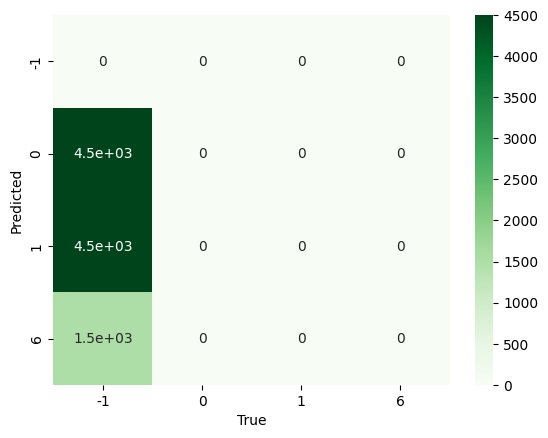

In [104]:
cf = confusion_matrix(y_train, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens", xticklabels=[-1,0,1,6], yticklabels=[-1,0,1,6])
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

Majority of ones are misclassified (lift was the lowest one).